# 1. Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

from pyod.models.iforest import IForest
from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import seaborn as sns
sns.set_style('white')

import warnings
warnings.filterwarnings(action='ignore')

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8574859294392214726
xla_global_id: -1
]
[]


In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

In [4]:
path = "./Dataset/"

dataT = pd.read_csv(path+"train_T.csv")  
dataO = pd.read_csv(path+"train_O.csv")  

# original data -> data
data = pd.concat([dataT, dataO]).reset_index(drop=True)
data

,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,0.529740,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834,1,0.532343,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,1,0.530533,T100304,O_31,4.0,98.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,2,0.535205,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Preprocessing

1. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1) 
2. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제 
3. 결측치 처리 (KNN Imputetor, fillna(0))
4. 정규화 (Robust, MinMax, Standard)
5. 카테고리 변수 수치화 (LINE, PRODUCT_CODE) LabelEncoder

In [13]:
# 1. Handling missing values  
# Preprocessed data -> processed_data
processed_data = data.drop(['Y_Quality'], axis=1).copy()
processed_data = processed_data.fillna(0)
processed_data

,Y_Class,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,45.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,53.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,60.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,53.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,T100304,O_31,154.0,97.0,0.0,45.0,11.0,0.0,45.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,T100306,O_31,146.0,94.0,0.0,45.0,10.0,0.0,67.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,T100304,O_31,4.0,98.0,0.0,45.0,11.0,0.0,45.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,T100306,O_31,6.0,89.0,0.0,45.0,10.0,0.0,51.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [14]:
# 2. 같은 값으로만 채워진 column 삭제 (nunique(dropna=False) <= 1)
# Get the counts of unique values per column
value_counts = processed_data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))

# Filter columns with only one unique value
unique_columns = value_counts[value_counts >= 2].index
duplicated_columns = value_counts[value_counts <= 1].index

processed_data = processed_data.drop(duplicated_columns, axis=1)
processed_data

,Y_Class,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,31.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,52.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,52.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,31.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,31.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [15]:
# 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
df = processed_data.iloc[:,4:].T.drop_duplicates(keep='first').T
processed_data = pd.concat([processed_data.iloc[:,:4], df], axis=1)
processed_data

,Y_Class,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,T100304,T_31,2.0,95.0,45.0,10.0,45.0,10.0,31.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,T100306,T_31,2.0,96.0,45.0,10.0,53.0,10.0,52.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,T100306,T_31,2.0,95.0,45.0,10.0,60.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,T100306,T_31,2.0,87.0,45.0,10.0,53.0,10.0,52.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,T100306,T_31,2.0,95.0,45.0,10.0,51.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,T100304,O_31,154.0,97.0,45.0,11.0,45.0,10.0,31.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,T100306,O_31,146.0,94.0,45.0,10.0,67.0,11.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,T100304,O_31,4.0,98.0,45.0,11.0,45.0,10.0,31.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,T100306,O_31,6.0,89.0,45.0,10.0,51.0,10.0,52.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [16]:
# 4. Regularization 
rs = RobustScaler()
ss = StandardScaler()

processed_data.iloc[:, 4:] = rs.fit_transform(processed_data.iloc[:, 4:])
processed_data

,Y_Class,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,T100304,T_31,2.0,0.0,0.0,0.0,-0.833333,0.0,-1.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,T100306,T_31,2.0,0.2,0.0,0.0,0.500000,0.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,T100306,T_31,2.0,0.0,0.0,0.0,1.666667,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,T100306,T_31,2.0,-1.6,0.0,0.0,0.500000,0.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,T100306,T_31,2.0,0.0,0.0,0.0,0.166667,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,1,T100304,O_31,154.0,0.4,0.0,1.0,-0.833333,0.0,-1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
834,1,T100306,O_31,146.0,-0.2,0.0,0.0,2.833333,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
835,1,T100304,O_31,4.0,0.6,0.0,1.0,-0.833333,0.0,-1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
836,2,T100306,O_31,6.0,-1.2,0.0,0.0,0.166667,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [17]:
# 5. Label Encoding 
cat_cols = ['PRODUCT_CODE', 'LINE']

for col in cat_cols:
    le = LabelEncoder()
    processed_data[col] = le.fit_transform(processed_data[col])
    print(le.classes_)

processed_data.head()

['O_31' 'T_31']
['T100304' 'T100306']


,Y_Class,LINE,PRODUCT_CODE,X_1,X_2,X_4,X_5,X_7,X_8,X_9,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0,1,2.0,0.0,0.0,0.0,-0.833333,0.0,-1.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,1,1,2.0,0.2,0.0,0.0,0.500000,0.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,1,1,2.0,0.0,0.0,0.0,1.666667,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
3,1,1,1,2.0,-1.6,0.0,0.0,0.500000,0.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,1,1,2.0,0.0,0.0,0.0,0.166667,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000


In [18]:
# # 5. 차원 축소
# from sklearn.decomposition import PCA 

# nonX_data = processed_data.iloc[:, :4]
# X_data = processed_data.iloc[:, 4:]

# pca = PCA(n_components=3)
# pca_data = pca.fit_transform(X_data) 
# pca_df = pd.DataFrame(pca_data, columns=['X1', 'X2', 'X3'])

# processed_data = pd.concat([nonX_data, pca_df], axis=1)
# processed_data

# 3. Data Split

In [19]:
# Divide processed_data to input_data_X and input_data_y 
input_data = processed_data.copy()
input_data_y = processed_data['Y_Class']
input_data_X = processed_data.drop(['Y_Class'], axis=1)

# train/ test data 로 split 
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = SEED,
    shuffle=True,
    stratify = input_data_y # importnat
)

# valid/train 로 split
train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y, 
    test_size = 0.2, 
    random_state = SEED,
    shuffle=True,
    stratify = tr_val_y # important 
)

print('Input Data X:', input_data_X.shape, 'Input Data y:', input_data_y.shape)
print('X_train:', train_X.shape, 'y_train:', train_y.shape)
print('X_valid:', valid_X.shape, 'y_train:', valid_y.shape)
print('X_test:', test_X.shape, 'y_train:', test_y.shape)

Input Data X: (838, 680) Input Data y: (838,)
X_train: (536, 680) y_train: (536,)
X_valid: (134, 680) y_train: (134,)
X_test: (168, 680) y_train: (168,)


# 4. Modeling 

1. Isolation Forest 
2. LOF (Local Outlier Factor)
3. PCA 
4. AutoEncoder 

In [22]:
from pycaret.classification import *
from time import time

In [28]:
# Setup Environment  
cat_cols = ['LINE', 'PRODUCT_CODE']
FOLD = 5

clf = setup(data = input_data, 
            train_size = 0.8,
            # test_data = test,
            target = 'Y_Class',
            ignore_features = cat_cols,
            preprocess = False,  # default True
#            categorical_features = cat_cols,
            fold_strategy = 'stratifiedkfold', # default 
            #numeric_features = num_cols,
            #ordinal_features = ord_dict,
            #high_cardinality_features = ['religion'],
            #high_cardinality_method = 'frequency',
            #handle_unknown_categorical = True,
            #normalize = True,
            #normalize_method = 'zscore', 
            #feature_selection = True, 
            #imputation_type='iterative',
            fold=FOLD, # defualt 10 
            fold_shuffle=True,
            use_gpu = True,
            session_id = SEED)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

,Description,Value
0,Session id,42
1,Target,Y_Class
2,Target type,Multiclass
3,Original data shape,"(838, 681)"
4,Transformed data shape,"(838, 679)"
5,Transformed train set shape,"(670, 679)"
6,Transformed test set shape,"(168, 679)"
7,Ignore features,2
8,Numeric features,678


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

In [29]:
# lasso, catboost, xgb, BayesianRidge, LassoLars
top5 = compare_models(sort='f1', n_select=5, fold=FOLD)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7851,0.7536,0.7851,0.7469,0.7458,0.2952,0.3306,0.2380
catboost,CatBoost Classifier,0.7836,0.7627,0.7836,0.7573,0.7410,0.2738,0.3183,21.1600
xgboost,Extreme Gradient Boosting,0.7806,0.7478,0.7806,0.7315,0.7388,0.2808,0.3159,1.4680
lightgbm,Light Gradient Boosting Machine,0.7806,0.7320,0.7806,0.7453,0.7376,0.2732,0.3135,5.7040
gbc,Gradient Boosting Classifier,0.7627,0.7409,0.7627,0.7231,0.7312,0.2755,0.2914,8.0820
rf,Random Forest Classifier,0.7761,0.7561,0.7761,0.7410,0.7235,0.2255,0.2716,0.2760
ada,Ada Boost Classifier,0.7552,0.6419,0.7552,0.7293,0.7211,0.2398,0.2661,0.6100
knn,K Neighbors Classifier,0.7597,0.7117,0.7597,0.7157,0.7210,0.2300,0.2553,0.0800
dt,Decision Tree Classifier,0.6806,0.5995,0.6806,0.6886,0.6826,0.2036,0.2051,0.1360
svm,SVM - Linear Kernel,0.7030,0.0000,0.7030,0.6593,0.6736,0.1421,0.1467,0.0640


In [ ]:
total_models = []
tuned_models = []

for i, model in enumerate(top5):
    cell_start_time = time() 
    print(top5[i])
    model = create_model(model, fold=FOLD)
    #tuned_model = tune_model(model, fold=FOLD, optimize='r2', choose_better=True)
    total_models.append(model)
    #tuned_models.append(tuned_model)
    cell_end_time = time()
    print("CELL RUN TIME: ", cell_end_time - cell_start_time)

In [ ]:
blender_top5 = blend_models(estimator_list=total_models)
#blender_tuned5 = blend_models(estimator_list=tuned_models)

In [ ]:
# for naive models 
total_predictions = []
for model in total_models: 
    pred = predict_model(model, raw_score=True)
    total_predictions.append(pred)
print() 

# for tuned models 
# for model in tuned_models: 
#     prediction = predict_model(model)
# print() 

# for blended model 
pred_blend_top5 = predict_model(blender_top5, raw_score=True)
print() 

# for blended model (tuned)
#pred_blend_tuned5 = predict_model(blender_tuned5)

In [58]:
evaluate_model(total_models[1])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

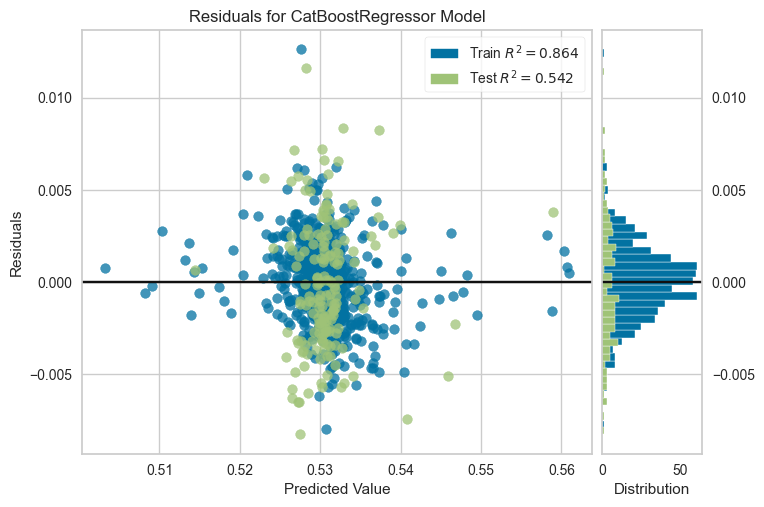

In [59]:
plot_model(total_models[1], plot='auc')

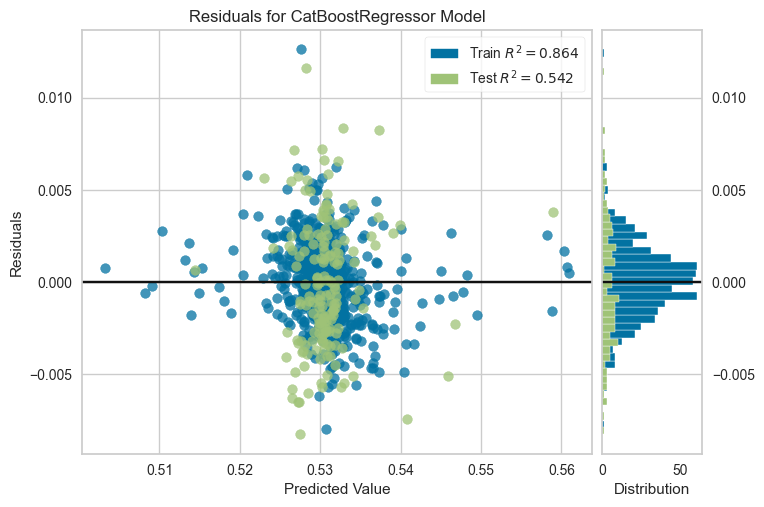

In [59]:
plot_model(total_models[1], plot='confusion_matrix')

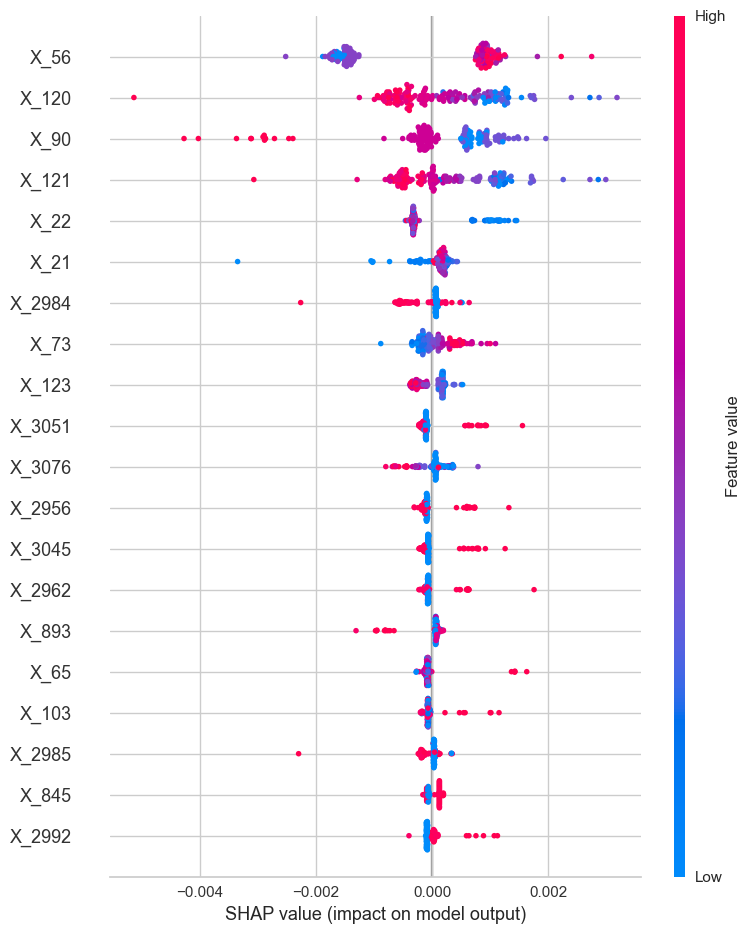

In [60]:
interpret_model(total_models[1], plot='summary')

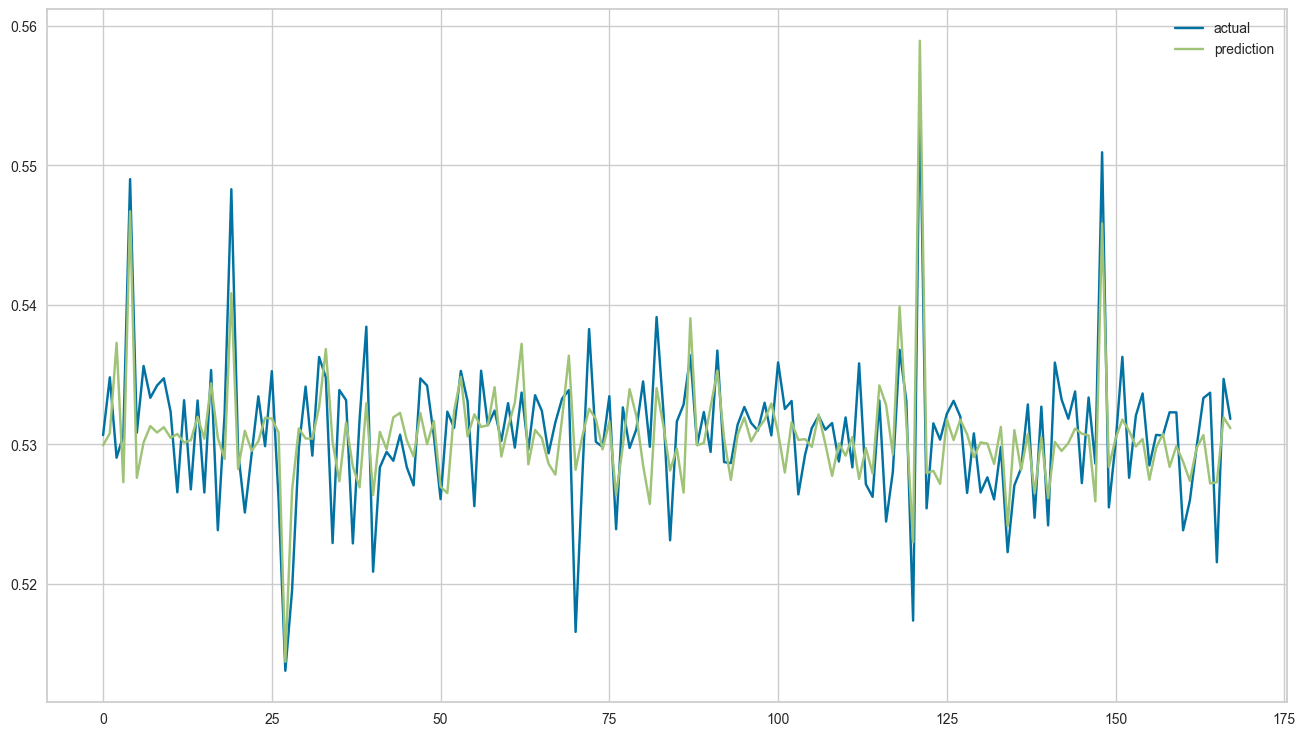

In [67]:
def graph(pred, true) :
    plt.figure(figsize=(16, 9))
    plt.plot(true, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

true_y = total_predictions[1]['Y_Quality'].to_numpy()
pred_y = total_predictions[1]['prediction_label'].to_numpy()
graph(pred_y, true_y)